# Logistic Regression 


In [1]:
import sys
sys.path.append('../')
import glob2 as glob

import copy
#import config
#import dota2api
import json
import requests
from pandas.io.json import json_normalize 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sns
#import plotly.express as px

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200


import warnings; warnings.simplefilter('ignore')

In [2]:
import time
import datetime
import pytz

In [3]:
def write_to_submission_file(predicted_labels, filename='logit_model'):
    df_submission = pd.DataFrame({'radiant_win_prob': predicted_labels}, 
                                     index=test_features.index)

    submission_filename = '{}_{}.csv'.format(filename,
        datetime.datetime.now(tz=pytz.timezone('US/Pacific')).strftime('%Y-%m-%d_%H-%M-%S'))
    
    df_submission.to_csv(submission_filename)
    
    print('Submission saved to {}'.format(submission_filename))

## Getting Hero Lookup 


https://medium.com/@waprin/python-and-dota2-analyzing-team-liquids-io-success-and-failure-7d44cc5979b2

Get hero names and ids

In [4]:
!curl https://api.opendota.com/api/heroes > heroes.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20607    0 20607    0     0  93244      0 --:--:-- --:--:-- --:--:-- 93244


In [5]:
hero_dict = {}
with open('heroes.json') as f:
    data = json.load(f)
    for h in data:
        hero_dict[h['id']] = h['localized_name']
#print(hero_dict)

In [6]:
# # STEAM Client API Key to access the dota2 api
#API_KEY = config.(96E9FAA2D511E90BFE0F1CE229834E0C)
#api = dota2api.Initialise(API_KEY)

In [7]:
# Cleaner way to create columns for re-naming 

col2 = [f'{i}hero_id' for i in range(1, 23)]
print(col2)

['1hero_id', '2hero_id', '3hero_id', '4hero_id', '5hero_id', '6hero_id', '7hero_id', '8hero_id', '9hero_id', '10hero_id', '11hero_id', '12hero_id', '13hero_id', '14hero_id', '15hero_id', '16hero_id', '17hero_id', '18hero_id', '19hero_id', '20hero_id', '21hero_id', '22hero_id']


In [8]:
# Run this once match data loaded in 

# https://github.com/codexponent/dota2-draft-analysis/blob/master/README.md

def change_hero_name(row):
    if row in hero_dict:
        return hero_dict[row]
    
columns = [
    '1hero_id',
    '2hero_id',
    '3hero_id',
    '4hero_id',
    '5hero_id',
    '6hero_id',
    '7hero_id',
    '8hero_id',
    '9hero_id',
    '10hero_id',
    '11hero_id',
    '12hero_id',
    '13hero_id',
    '14hero_id',
    '15hero_id',
    '16hero_id',
    '17hero_id',
    '18hero_id',
    '19hero_id',
    '20hero_id',
    '21hero_id',
    '22hero_id'
]
    
for i in range(len(columns)):
   df_full_features1[columns[i]] = df_full_features1[columns[i]].apply(change_hero_name)

NameError: name 'df_full_features1' is not defined

In [ ]:
df_full_features1.shape

In [ ]:
rhero_train = df_full_features1

In [ ]:
#rhero_train.count

In [ ]:
heroes_df = df_full_features[[f'{i}hero_id' for i in range(1, 23)]]

## Logistic Regression 

Try doing logistic regression with just hot encoded heroes and see what results are like

In [9]:
SEED = 17

In [109]:
# Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

SEED = 17

In [80]:
# Import Training and Test Data  
train_features = pd.read_csv('data2/dpc_train_features.csv', index_col='match_id')
train_targets = pd.read_csv('data2/dpc_train_target.csv', index_col='match_id')
test_features = pd.read_csv('data2/dpc_test_features.csv', index_col='match_id')
test_targets = pd.read_csv('data2/dpc_test_target.csv', index_col='match_id')

In [81]:
train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

((1045, 66), (1045, 2), (117, 66), (117, 2))

In [6]:
merge_features_df = pd.concat([train_features, test_features])

# Index to split the training and test data sets
idx_split = train_features.shape[0]

heroes_df = df_full_features[[f'{i}hero_id' for i in range(1, 23)]]

NameError: name 'df_full_features' is not defined

In [14]:
df_full_features1 = df_full_features.copy()

In [15]:
heroes_df1 = heroes_df.copy()

In [16]:
heroes_df.shape

(1162, 22)

In [ ]:
# Quick check that hero ids are unique (i.e., no double picking)
# https://www.kaggle.com/kuzand/dota-2-winner-prediction-multilayer-nn-pytorch

np.all(df_full_features[[f'{i}hero_id' for i in range(1, 23)]].nunique(axis=1) == 22)

In [ ]:
np.sort(np.unique(heroes_df[[f'{i}hero_id' for i in range(1, 23)]].values.flatten()))

In [ ]:
(unique, counts) = np.unique(heroes_df[[f'{i}hero_id' for i in range(1, 23)]],return_counts=True) 
frequencies = np.asarray((unique, counts)).T

print(frequencies)

In [17]:
heroes_df_ohe = heroes_df.copy()
for i in range(1, 23):
    heroes_df_ohe = pd.get_dummies(heroes_df_ohe, columns = [f'{i}hero_id'])
        
heroes_df_ohe.head()

X_heroes_train = heroes_df_ohe[:idx_split] # features set is only picks + dummies
X_heroes_test  = heroes_df_ohe[idx_split:]

In [18]:
print(f'Number of features: {heroes_df_ohe.shape[1]}')

Number of features: 2044


In [19]:
X_heroes_train.shape, X_heroes_test.shape

((1045, 2044), (117, 2044))

In [20]:
X_heroes_train.head()

,1hero_id_2,1hero_id_3,1hero_id_4,1hero_id_6,1hero_id_7,1hero_id_9,1hero_id_10,1hero_id_16,1hero_id_18,1hero_id_19,1hero_id_23,1hero_id_25,1hero_id_27,1hero_id_29,1hero_id_31,1hero_id_33,1hero_id_37,1hero_id_38,1hero_id_40,1hero_id_41,1hero_id_42,1hero_id_43,1hero_id_46,1hero_id_52,1hero_id_53,1hero_id_55,1hero_id_57,1hero_id_58,1hero_id_59,1hero_id_60,1hero_id_61,1hero_id_62,1hero_id_65,1hero_id_66,1hero_id_68,1hero_id_69,1hero_id_71,1hero_id_72,1hero_id_73,1hero_id_74,1hero_id_75,1hero_id_76,1hero_id_79,1hero_id_80,1hero_id_81,1hero_id_82,1hero_id_83,1hero_id_84,1hero_id_85,1hero_id_86,1hero_id_87,1hero_id_88,1hero_id_89,1hero_id_90,1hero_id_91,1hero_id_93,1hero_id_96,1hero_id_97,1hero_id_98,1hero_id_99,1hero_id_102,1hero_id_103,1hero_id_104,1hero_id_105,1hero_id_106,1hero_id_107,1hero_id_111,1hero_id_112,1hero_id_119,1hero_id_120,1hero_id_121,1hero_id_129,2hero_id_2,2hero_id_3,2hero_id_4,2hero_id_7,2hero_id_9,2hero_id_10,2hero_id_16,2hero_id_17,2hero_id_18,2hero_id_19,2hero_id_22,2hero_id_23,2hero_id_25,2hero_id_29,2hero_id_31,2hero_id_33,2hero_id_37,2hero_id_38,2hero_id_41,2hero_id_42,2hero_id_43,2hero_id_46,2hero_id_50,2hero_id_52,2hero_id_53,2hero_id_54,2hero_id_55,2hero_id_57,...,22hero_id_1,22hero_id_2,22hero_id_4,22hero_id_5,22hero_id_6,22hero_id_7,22hero_id_8,22hero_id_10,22hero_id_11,22hero_id_12,22hero_id_13,22hero_id_14,22hero_id_15,22hero_id_16,22hero_id_17,22hero_id_18,22hero_id_19,22hero_id_21,22hero_id_22,22hero_id_23,22hero_id_25,22hero_id_26,22hero_id_27,22hero_id_28,22hero_id_29,22hero_id_32,22hero_id_33,22hero_id_34,22hero_id_35,22hero_id_36,22hero_id_37,22hero_id_38,22hero_id_39,22hero_id_40,22hero_id_41,22hero_id_42,22hero_id_43,22hero_id_44,22hero_id_45,22hero_id_46,22hero_id_47,22hero_id_48,22hero_id_49,22hero_id_50,22hero_id_51,22hero_id_52,22hero_id_53,22hero_id_54,22hero_id_55,22hero_id_56,22hero_id_57,22hero_id_58,22hero_id_59,22hero_id_60,22hero_id_61,22hero_id_62,22hero_id_63,22hero_id_65,22hero_id_67,22hero_id_68,22hero_id_70,22hero_id_71,22hero_id_72,22hero_id_73,22hero_id_74,22hero_id_75,22hero_id_76,22hero_id_77,22hero_id_78,22hero_id_79,22hero_id_80,22hero_id_81,22hero_id_82,22hero_id_84,22hero_id_85,22hero_id_86,22hero_id_88,22hero_id_89,22hero_id_92,22hero_id_93,22hero_id_94,22hero_id_95,22hero_id_96,22hero_id_97,22hero_id_98,22hero_id_99,22hero_id_101,22hero_id_102,22hero_id_104,22hero_id_106,22hero_id_107,22hero_id_108,22hero_id_109,22hero_id_110,22hero_id_112,22hero_id_113,22hero_id_114,22hero_id_120,22hero_id_121,22hero_id_129
match_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5115031896,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4865407245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4889341660,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5050335216,0,0,0,0,0,0,0,0,0,0,0

Hot encoding by getting dummies for each hero_id feature.

*Note: Not every 117 heroes were chosen for each pick (1-22). Therefore, columns will be less than 22 x 117

### One Hot Encoding Features

In [82]:
all_features = pd.concat([train_features, test_features])

# Index to split the training and test data sets
idx_split = train_features.shape[0]

In [83]:
for i in range(1,23):
        all_features = pd.get_dummies(all_features, columns = [f'{i}hero_id'])

print(all_features.shape)

(1162, 2088)


### Scaling 

Trying it out with minmax. From what I can tell, this seems like the most appropriate scaling method. 

In [ ]:
df_full_features_scaled = df_full_features.copy()
df_full_features_scaled[df_full_features.columns.tolist()] = MinMaxScaler().fit_transform(df_full_features_scaled[df_full_features.columns.tolist()])  # alternatively use StandardScaler

In [ ]:
df_full_features_scaled.head()

In [ ]:
df_full_features_scaled.shape

Okay, looks like we have the entire data set hot encoded and scaled (minmax). Time to split it back up and go forward. 

## Set targets, features, and verification set 

Should the combined train sets still have hero variables? did I do this right?

In [85]:
# Encoded train/test features
# Try this once without scaling 

X_train = all_features[:idx_split]
X_test = all_features[idx_split:]

y_train = train_targets.radiant_win
y_test = test_targets.radiant_win

In [106]:
X_remainder = all_features[:idx_split]
X_test = all_features[idx_split:]

y_remainder = train_targets.radiant_win.values
y_test = test_targets.radiant_win.values

In [86]:
# keep full version of training set to use for final accuracy model 
X_train_full = X_train.copy() 
y_train_full = y_train.copy()

In [96]:

train_features_ohe = X_train_full
test_features_ohe = y_train_full
train_features_ohe.shape, test_features_ohe.shape, y_train.shape, y_test.shape

((1045, 2088), (1045,), (1045,), (105,))

In [15]:
# Check to make sure everything is correct size
X_train.shape, X_train_full.shape, X_test.shape, y_train.shape, y_train_full.shape, y_test.shape

((1045, 2088), (1045, 2088), (117, 2088), (1045,), (1045,), (117,))

Everything seems in order, let's do our validation split and get into the modelliing. 

### Train Validation Split

Train Validation Split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state = SEED) ## see top, SEED = 17

In [17]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((940, 2088), (105, 2088), (940,), (105,))

In [18]:
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of validation set: {X_valid.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (117, 2088)
Shape of validation set: (105, 2088)
Shape of train set: (940, 2088)


In [68]:
## Logit Model 1. 

### Logistic Regression 1. 

Let's see what the out of the box results are like. Without scaling

In [29]:
logit1 = LogisticRegression(random_state=random_state, n_jobs=-1)

In [30]:
%%time
logit1.fit(X_train, y_train)
y_pred = logit1.predict(X_valid)
y_pred_proba = logit1.predict_proba(X_valid)

print(f"Accuracy Score on Train Set: {logit1.score(X_train, y_train)}")
print(f"Accuracy Score on validation Set: {logit1.score(X_valid, y_valid)}")
print(f'Logit model validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

Accuracy Score on Train Set: 0.9968085106382979
Accuracy Score on validation Set: 0.4666666666666667
Logit model validation roc_auc score: 0.4660740203193033
Wall time: 3.95 s


### Scaling data 

For comparison, let's compare out of the box results after scaling the data. Scaling data after the two splits to avoid data leakage.

In [68]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train1, X_valid1, X_test1 = X_train.copy(), X_valid.copy(), X_test.copy()

X_train_scaled = scaler.fit_transform(X_train1)
X_valid_scaled = scaler.fit_transform(X_valid1)
X_test_scaled = scaler.fit_transform(X_test1)

In [69]:
logit2 = LogisticRegression(random_state=random_state, n_jobs=-1)

In [70]:
%%time
logit2.fit(X_train_scaled, y_train)
y_pred = logit1.predict(X_valid)
y_pred_proba = logit2.predict_proba(X_valid_scaled)

print(f"Accuracy Score on Train Set: {logit2.score(X_train_scaled, y_train)}")
print(f"Accuracy Score on validation Set: {logit2.score(X_valid_scaled, y_valid)}")

print(f'Log Regression validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

Accuracy Score on Train Set: 0.9968085106382979
Accuracy Score on validation Set: 0.4666666666666667
Log Regression validation roc_auc score: 0.4660740203193033
Wall time: 4.05 s


Wow what a surprise, since all my features return values of 0 or 1, scaling doesn't do anything. 

## Testing Machine Learning Methods

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

logreg = LogisticRegression(random_state=17)
forest = RandomForestClassifier(random_state=17)
bayes = MultinomialNB()
xg = XGBClassifier(random_state=17)
cat = CatBoostClassifier()

In [ ]:

X_remainder_scaled = MinMaxScaler().fit_transform(X_train1)
#X_valid_scale = MinMaxScaler().fit_transform(X_valid1)

In [123]:
classifiers = [logreg, forest, xg, bayes]
acc_train = []
acc_test = []

In [120]:
#cv = ShuffleSplit(n_splits=5, random_state=SEED) #using a shuffle split for CV 

In [124]:
%%time
#THIS CELL TAKES A WHILE TO RUN
for i in classifiers:
    X_train, X_valid, y_train, y_valid = train_test_split(X_remainder, y_remainder, test_size=0.1, random_state=17)

    scores = cross_val_score(i, X_train, y_train, cv=5)
    acc_train.append(np.mean(scores))
    
    model = i.fit(X_train, y_train)
    #y_pred_valid = i.predict(X_valid)
    acc_test.append(model.score(X_valid, y_valid))

Wall time: 23.7 s


In [125]:
summary_base = pd.DataFrame({'models': classifiers,
              'Training Accuracy': acc_train,
              'Validation Accuracy': acc_test})
summary_base

,models,Training Accuracy,Validation Accuracy
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.490426,0.466667
1,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",0.484043,0.380952
2,"XGBClassifier(base_score=0.5, booster=None, co...",0.482979,0.419048
3,"MultinomialNB(alpha=1.0, class_prior=None, fit...",0.523404,0.466667


In [ ]:
tuned_parameters = {'C':[.00000001,.0000001,.000001,.00001,.0001,.001,.01, .1,\
                          1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000],
                     'penalty': ['l1', 'l2']}


In [27]:
%%time
# https://www.kaggle.com/smsrikanthreddy/dota-2-win-prediction-logistic-regression

#calcuate ROC-AUC for each split
#logistic Regression
C = 1
penalty = 'l2'
max_iter = 100
solver = 'lbfgs'
random_state = SEED
n_jobs = -1
verbose = 0

logit1 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)

#cv_scores_lr1 = cross_val_score(clf_lr_1, X_train, y, cv=cv, scoring='roc_auc')

Wall time: 0 ns


In [21]:
%%time
logit1.fit(X_train, y_train)
y_pred = logit1.predict(X_valid)
y_pred_proba = logit1.predict_proba(X_valid)

print(f"Accuracy Score on Train Set: {logit1.score(X_train, y_train)}")
print(f"Accuracy Score on validation Set: {logit1.score(X_valid, y_valid)}")

print(f'Logit model validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

Accuracy Score on Train Set: 0.9968085106382979
Accuracy Score on validation Set: 0.4666666666666667
Logit model validation roc_auc score: 0.4660740203193033
Wall time: 3.67 s


In [25]:
#print(f"Predict Probability on Train Set: {logit1.predict_proba(X_train)}")
#print(f"Predict Probability on Train Set: {logit1.predict_proba(X_valid)}")

Well those don't look too good 

In [24]:
#logit1.predict_proba(X_valid)

In [43]:
#from sklearn.linear_model import LogisticRegression

validation_scores = []
train_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,0.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

for c in C_range:
    logit = LogisticRegression(C = c,random_state=SEED)
    logit.fit(X_train,y_train)
    
    # train on traning set
    train_scores.append(logit.score(X_train,y_train))
    # score on validation set
    validation_scores.append(logit.score(X_valid,y_valid))

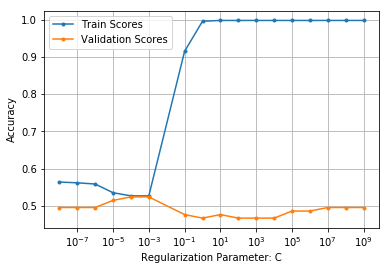

In [44]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Scores",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Accuracy')
plt.grid()
plt.show();

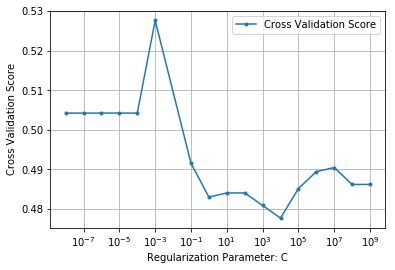

The best model has C =  0.001
CPU times: user 27.5 s, sys: 457 ms, total: 27.9 s
Wall time: 17.1 s


In [46]:
%%time
#Store the results
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Do some cross validation
for c in C_range:
    logit = LogisticRegression(C=c,random_state=SEED, solver = 'lbfgs')
    
    #the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(logit, X_train, y_train, cv = 5))
    
    cross_validation_scores.append(cv_score)

plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

which_max = np.array(cross_validation_scores).argmax()

print("The best model has C = ",C_range[which_max])

In [58]:
for i in range(len(cross_validation_scores)):
    print(f'Fold {i+1}: {cross_validation_scores[i]}')

Fold 1: 0.5042553492490913
Fold 2: 0.5042553492490913
Fold 3: 0.5042553492490913
Fold 4: 0.5042553492490913
Fold 5: 0.5042553492490913
Fold 6: 0.5276939789455434
Fold 7: 0.49156861541091834
Fold 8: 0.4830012684205425
Fold 9: 0.48404809162005663
Fold 10: 0.48405372034908956
Fold 11: 0.4808904348328628
Fold 12: 0.4776818786831303
Fold 13: 0.48515707164017546
Fold 14: 0.48944077523551865
Fold 15: 0.4904763409769668
Fold 16: 0.48620401524031054
Fold 17: 0.48620401524031054


In [53]:
#Settling a CV scheme.
cv = ShuffleSplit(n_splits=5, random_state=SEED) #using a shuffle split for CV 

In [111]:
#calcuate ROC-AUC for each split
#logistic Regression
C = 0.001
penalty = 'l2'
max_iter = 100
solver = 'lbfgs'
random_state = SEED
n_jobs = -1
verbose = 0
class_weight = 'balanced'

final_logit1 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)

In [112]:
#final_logit1 = LogisticRegression(C=0.001, random_state=SEED, n_jobs=-1, solver='lbfgs')


final_logit1.fit(X_train_full, y_train_full)
final_logit1.score(X_test, y_test)
print(f'Final Logit1 test score: {final_logit1.score(X_test, y_test)}')
#print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit1 test score: 0.5128205128205128


In [121]:
y_pred = final_logit1.predict(X_test)
y_pred_proba = final_logit1.predict_proba(X_test)
#print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

In [122]:
print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit1 test roc_auc score: 0.5054711246200608


So, final scores from out of the box logistic regression look pretty shit 

## Logit Model 2 

Let's try this with scaling 

### Scaling data 

In [74]:
from sklearn.preprocessing import MinMaxScaler

X_train1, X_valid1, X_test1 = X_train.copy(), X_valid.copy(), X_test.copy()

X_train_scaled = MinMaxScaler().fit_transform(X_train1)
X_valid_scaled = MinMaxScaler().fit_transform(X_valid1)
X_test_scaled = MinMaxScaler().fit_transform(X_test1)


In [88]:
%%time
# https://www.kaggle.com/smsrikanthreddy/dota-2-win-prediction-logistic-regression

#calcuate ROC-AUC for each split
#logistic Regression
#logit_params 
C = 0.001
penalty = 'l2'
max_iter = 100
solver = 'lbfgs'
random_state = SEED
n_jobs = -1
verbose = 0


logit2 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)

#cv_scores_lr1 = cross_val_score(clf_lr_1, X_train, y, cv=cv, scoring='roc_auc')

CPU times: user 30 µs, sys: 1e+03 ns, total: 31 µs
Wall time: 36 µs


In [78]:
%%time
logit2.fit(X_train_scaled, y_train)
y_pred = logit1.predict(X_valid)
y_pred_proba = logit2.predict_proba(X_valid_scaled)

print(f"Accuracy Score on Train Set: {logit2.score(X_train_scaled, y_train)}")
print(f"Accuracy Score on validation Set: {logit2.score(X_valid_scaled, y_valid)}")

print(f'Log Regression validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

Accuracy Score on Train Set: 0.5358851674641149
Accuracy Score on validation Set: 0.5333333333333333
Log Regression validation roc_auc score: 0.4660740203193033
CPU times: user 66.8 ms, sys: 57 ms, total: 124 ms
Wall time: 1.95 s


In [95]:
X_remainder = X_train_full.copy()
y_remainder = y_train_full.copy()

In [131]:
X_remainder.shape

(1045, 2088)

In [96]:
X_remainder_scaled = MinMaxScaler().fit_transform(X_remainder)

In [128]:
final_logit2 = LogisticRegression(C=0.001, random_state=SEED, n_jobs=-1, solver='lbfgs')

final_logit2.fit(X_remainder_scaled, y_remainder)
final_logit2.score(X_test_scaled, y_test)
print(f'Final Logit2 test score: {final_logit1.score(X_test_scaled, y_test)}')
#print(f'Final Logit2 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit2 test score: 0.5128205128205128


In [130]:
y_pred = final_logit2.predict(X_test_scaled)
y_pred_proba = final_logit2.predict_proba(X_test_scaled)
print(f'Final Logit1 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

Final Logit1 test roc_auc score: 0.5054711246200608


In [134]:
y_prob = classifier.predict_proba(X_test)

NameError: name 'classifier' is not defined

In [133]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[38, 25],
       [32, 22]])

In [123]:
final_logit2 = LogisticRegression(C=0.001, random_state=SEED, n_jobs=-1, solver='lbfgs')

y_pred = final_logit2.predict(X_test_scaled)
y_pred_proba = final_logit2.predict_proba(X_test_scaled)

final_logit2.fit(X_remainder_scaled, y_remainder)
#final_logit2.score(X_test, y_test)
print(f'Final Logit2 test score: {final_logit2.score(X_test_scaled, y_test)}')
print(f'Final Logit2 test roc_auc score: {roc_auc_score(y_pred, y_test)}')

NotFittedError: This LogisticRegression instance is not fitted yet

Computing Logit model cv scores 

In [ ]:
%%time
# Computing logit cv scores

logit_0, cv_scores_0 = logit_cv(X_train, y_train, cv=skf, random_state=SEED)

In [ ]:
logit_0
print(f"Accuracy Score on Train Set: {logit_0.score(X_train, y_train)}")
print(f"Predict Probability on Train Set: {logit_0.score(X_train, y_train)}")
print(f'Log Regression validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

## Logistic Regression

To summarize what we're working with. The data has been hot encoded (pd.dummy) and scaled (minmax). After that, we performed another split on the training data to create a validation set for the purpose of hyperparameter tuning.  

### Grid Search 1. 



In [ ]:
## Source: https://www.kaggle.com/kuzand/bag-of-heroes-logistic-regression#notebook-container

def logit_cv(X_train, y_train, cv=5, random_state=SEED):
    
    logit = LogisticRegression(random_state=SEED, solver='liblinear')

    c_values = np.logspace(-2, 1, 20)

    logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                       scoring='roc_auc',return_train_score=True, cv=cv,
                                       n_jobs=-1, verbose=0)

    logit_grid_searcher.fit(X_train, y_train)
    
    cv_scores = []
    for i in range(logit_grid_searcher.n_splits_):
        cv_scores.append(logit_grid_searcher.cv_results_[f'split{i}_test_score'][logit_grid_searcher.best_index_])
    print(f'CV scores: {cv_scores}\n')
    print(f'Mean: {np.mean(cv_scores)}, std: {np.std(cv_scores)}\n')
    
    return logit_grid_searcher.best_estimator_, np.array(cv_scores) 

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [ ]:
#logit = logit_cv(X_train, y_train, cv=skf, random_state=SEED)[0]

Computing Logit model cv scores 

In [ ]:
%%time
# Computing logit cv scores

logit_0, cv_scores_0 = logit_cv(X_train, y_train, cv=skf, random_state=SEED)

In [ ]:
logit_0
print(f"Accuracy Score on Train Set: {logit_0.score(X_train, y_train)}")
print(f"Predict Probability on Train Set: {logit_0.score(X_train, y_train)}")
print(f'Log Regression validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

In [39]:
logit.fit(X_train, y_train)
y_pred = logit.predict(X_valid)
y_pred_proba = logit.predict_proba(X_valid)

print(f"Accuracy Score on Train Set: {logit.score(X_train, y_train)}")
print(f"Predict Probability on Train Set: {logit.score(X_train, y_train)}")
print(f"Accuracy Score on validation Set: {logit.score(X_valid, y_valid)}")
print(f'Log Regression validation roc_auc score: {roc_auc_score(y_pred, y_valid)}')

NameError: name 'logit' is not defined

In [ ]:
logit.fit(X_train, y_train)

logit_pred = logit.predict_proba(X_valid)

write_to_submission_file(logit_pred, filename='logit_model')